# Modeling Part 1. Univariate Time Series Analysis.

## Table of Contents
- [Importing Necessary Libraries & Loading Data](#Importing-Necessary-Libraries-&-Loading-Dsta)
- [Plotting & Interpreting Time Series](#Plotting-&-Interpreting-Time-Series)
- [Modeling](#Modeling)
    - [ARIMA Model](#ARIMA-Model)
    - [SARIMA Model](#SARIMA-Model)
    

## Importing Necessary Libraries & Loading Data

In [1]:
#pip install pmdarima

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


from datetime import datetime

import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pmdarima as pm

# This will allow us to avoid a FutureWarning when plotting.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from warnings import catch_warnings
from warnings import filterwarnings
import warnings

warnings.simplefilter(action="ignore")


Reading in daily soybean prices dataframe.

In [13]:
daily_price = pd.read_csv('../Data/settlement_price_df.csv')
daily_price.head()

,Date,Settlement Price
0,1990-01-02,5.613
1,1990-01-03,5.673
2,1990-01-04,5.633
3,1990-01-05,5.645
4,1990-01-08,5.707


In [14]:
daily_price.dtypes

Date                 object
Settlement Price    float64
dtype: object

Since we will be performing time series analyses on the data, we acre converting the 'DATE' column to datetime format, setting it as the index, and sorting the dataframe ascending by date. We are also modifying date range so from 1/1/1990 to 12/31/2019.

In [15]:
daily_price['Date'] = pd.to_datetime(daily_price['Date'])
daily_price.set_index('Date', inplace=True)
daily_price.sort_index(inplace=True)
daily_price = daily_price[daily_price.index<'2020-01-01']
daily_price.tail()

,Settlement Price
Date,
2019-12-24,9.365
2019-12-26,9.465
2019-12-27,9.415
2019-12-30,9.525
2019-12-31,9.555


In [16]:
daily_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7559 entries, 1990-01-02 to 2019-12-31
Data columns (total 1 columns):
Settlement Price    7559 non-null float64
dtypes: float64(1)
memory usage: 118.1 KB


### Line Plot of Monthly, Quarterly, and Annual Rolling Means

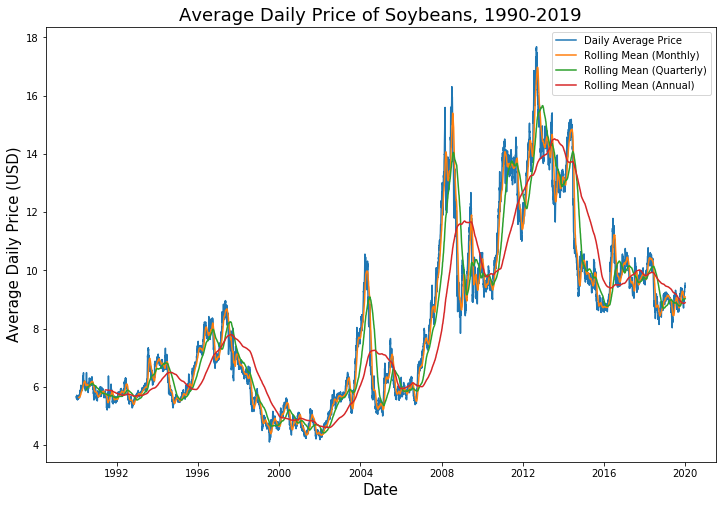

In [8]:
plt.figure(figsize=(12, 8))
plt.plot(daily_price, label='Daily Average Price')
plt.plot(daily_price.rolling(30).mean(), label='Rolling Mean (Monthly)')
plt.plot(daily_price.rolling(120).mean(), label='Rolling Mean (Quarterly)')
plt.plot(daily_price.rolling(365).mean(), label='Rolling Mean (Annual)')
plt.legend()
plt.ylabel('Average Daily Price (USD)', fontsize = 15)
plt.xlabel('Date', fontsize = 15)
plt.title('Average Daily Price of Soybeans, 1990-2019', fontsize = 18);
plt.savefig('../Images/AvDailyPriceRolling.png')

We can see from this data that there is seasonality on approximately a quarterly basis. This makes sense intuitively, as each seasonal component of the soybean lifecycle lasts for approximately 3 months.

### ACF and PACF Plots

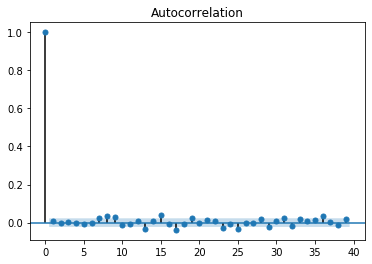

In [12]:
plot_acf(daily_price.diff().dropna());

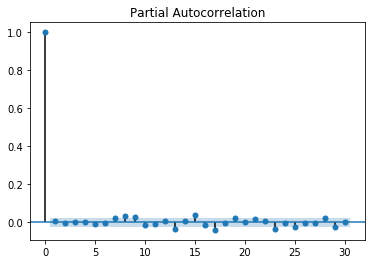

In [13]:
plot_pacf(daily_price.diff().dropna(), lags = 30);

One assumption to using the Autoregressive Integrated Moving Average (ARIMA) model is that the data is stationary. Therefore, I will check the stationarity of my data using an Augmented Dickey-Fuller Test.

### Augmented Dickey-Fuller Test
Using $\alpha$ = 0.05, I will perform the following hypothesis test:  
$H_0$= not stationary  
$H_A$ = stationary

In [14]:
# Dickey-Fuller Test
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [15]:
interpret_dftest(adfuller(daily_price['Settlement Price']))

Test Statistic   -2.26793
p-value           0.18252
dtype: float64

Since $\alpha$ < p-value = 0.18, we cannot reject the null hypothesis. So, I will take the difference and perform the test again.

In [16]:
interpret_dftest(adfuller(daily_price['Settlement Price'].diff(1).dropna()))

Test Statistic   -1.363389e+01
p-value           1.702822e-25
dtype: float64

Since $\alpha$ > p-value, we can reject the null hypothesis and accept the alternative hypothesis that the data is stationary. We can now model our time series data.

## Modeling

I am dividing my data into training data and testing data, with my training data consisting of data from 1990-2016 and my testing data consisting of data from 2017-2019.  I will use my training data to "train" my model, and evaluate it based on the mean absolute error between by test data (actual) and my predictions for that same date range using my model. 

*NOTE While new futures contracts are typically one year out, investors may buy/sell these contracts up until its expiry data, and therefore, I did not include a lag between my training and testing data.*

In [17]:
train = daily_price[daily_price.index<'2017-01-01']
test = daily_price[daily_price.index>='2017-01-01']

### ARIMA Model

Gridsearching for the values of the ARIMA hyperparameters p and q, given d = 1 (as determined in our Augmented Dickey-Fuller Test), that minimizes the AIC on the training data.  

In [18]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0
# Iterating over values of p and q.
for p in range(5):
    for q in range(5):
        try:
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting to fit ARIMA({p}, 1, {q}) model.')
            # Instantiate ARIMA model.
            arima = ARIMA(endog = train.astype(float).dropna(), # endog = Y variable
                          order = (p, 1, q))
            # Fit ARIMA model.
            model = arima.fit()
            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')
            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q
        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit ARIMA(0, 1, 0) model.
The AIC for ARIMA(0,1,0) is: -7380.874614412662
Attempting to fit ARIMA(0, 1, 1) model.
The AIC for ARIMA(0,1,1) is: -7379.563696014899
Attempting to fit ARIMA(0, 1, 2) model.
The AIC for ARIMA(0,1,2) is: -7377.637231125267
Attempting to fit ARIMA(0, 1, 3) model.
The AIC for ARIMA(0,1,3) is: -7375.664162086763
Attempting to fit ARIMA(0, 1, 4) model.
The AIC for ARIMA(0,1,4) is: -7373.667847666518
Attempting to fit ARIMA(1, 1, 0) model.
The AIC for ARIMA(1,1,0) is: -7379.559119601177
Attempting to fit ARIMA(1, 1, 1) model.
The AIC for ARIMA(1,1,1) is: -7377.644518575111
Attempting to fit ARIMA(1, 1, 2) model.
The AIC for ARIMA(1,1,2) is: -7375.6476979916915
Attempting to fit ARIMA(1, 1, 3) model.
The AIC for ARIMA(1,1,3) is: -7373.664525493128
Attempting to fit ARIMA(1, 1, 4) model.
The AIC for ARIMA(1,1,4) is: -7371.717086781729
Attempting to fit ARIMA(2, 1, 0) model.
The AIC for ARIMA(2,1,0) is: -7377.635477143285
Attempting to fit ARIMA(2, 1, 1

The model that minimizes AIC on the testing data has p=4 and q=4, so I will run the ARIMA(4,1,4) model.

In [35]:
model = ARIMA(endog = train.astype(float).dropna(),
              order = (4,1,4))
arima = model.fit()

In [36]:
forecast, stderr, conf_int = arima.forecast(len(test), alpha = 0.05)

In [37]:
print(f'MAE = {mean_absolute_error(test, forecast)}')

MAE = 0.9780106543961353


In [38]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:     D.Settlement Price   No. Observations:                 6804
Model:                 ARIMA(4, 1, 4)   Log Likelihood                3719.537
Method:                       css-mle   S.D. of innovations              0.140
Date:                Wed, 11 Mar 2020   AIC                          -7419.075
Time:                        08:39:01   BIC                          -7350.822
Sample:                             1   HQIC                         -7395.522
                                                                              
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0007      0.002      0.385      0.700      -0.003       0.004
ar.L1.D.Settlement Price     0.2747      0.008     35.828      0.000       0.260       0.290
ar.L2.D.Settlement Price    -0.8003      0.011    -72.988      0.000      -0.822      -0.779
ar.L3.D.Settlement Price     0.2696      0.011     24.440      0.000       0.248       0.291
ar.L4.D.Settlement Price    -0.9791      0.008   -119.676      0.000      -0.995      -0.963
ma.L1.D.Settlement Price    -0.2718      0.010    -27.009      0.000      -0.292      -0.252
ma.L2.D.Settlement Price     0.7980      0.015     53.629      0.000       0.769       0.827
ma.L3.D.Settlement Price    -0.2627      0.015    -17.421      0.000      -0.292      -0.233
ma.L4.D.Settlement Price     0.9622      0.011     85.036      0.000       0.940       0.984
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.4841           -0.8817j            1.0058           -0.3299
AR.2           -0.4841           +0.8817j            1.0058            0.3299
AR.3            0.6217           -0.7893j            1.0048           -0.1438
AR.4            0.6217           +0.7893j            1.0048            0.1438
MA.1           -0.4859           -0.8861j            1.0106           -0.3298
MA.2           -0.4859           +0.8861j            1.0106            0.3298
MA.3            0.6224           -0.7939j            1.0087           -0.1442
MA.4            0.6224           +0.7939j            1.0087            0.1442
-----------------------------------------------------------------------------
"""

In [39]:
resid = test['Settlement Price']-forecast

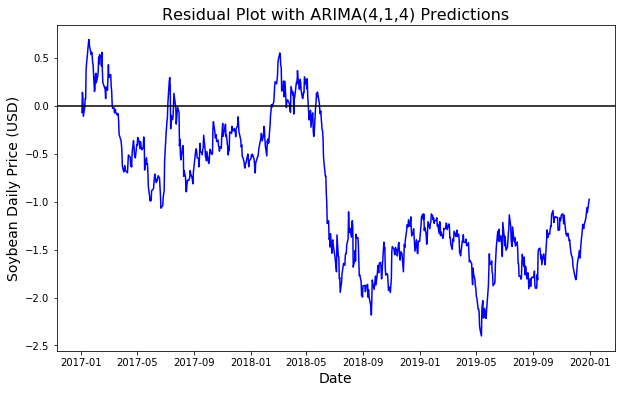

In [40]:
plt.figure(figsize=(10,6))
plt.plot(resid,color = 'blue') 
plt.ylabel('Soybean Daily Price (USD)', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.title(label = 'Residual Plot with ARIMA(4,1,4) Predictions', fontsize=16) 
plt.axhline(0, color = 'k', ls = '-')
plt.show();

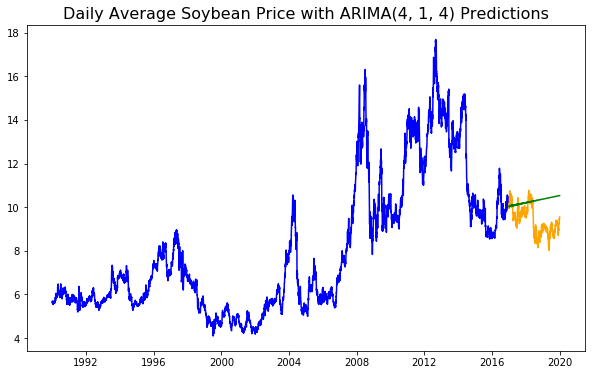

In [41]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(train.index, train['Settlement Price'], color = 'blue', label = 'Training Prices')

# Plot testing data.
plt.plot(test.index, test['Settlement Price'], color = 'orange', label = 'Actual Prices')

# Plot predicted test values.
plt.plot(test.index, forecast, color = 'green', label = 'ARIMA Predictions')

plt.title(label = 'Daily Average Soybean Price with ARIMA(4, 1, 4) Predictions', fontsize=16);

Note that our model expects the price to increase with inflation. However, in June 2018, there was speculation of a trade war between the US and China, one of the US's largest soybean customers, and so the market quickly responded to this potential drop in demand with a price drop.  A month later, in July 2018, this speculation was confirmed as China imposed a 25% import tariff on US Soybeans. 

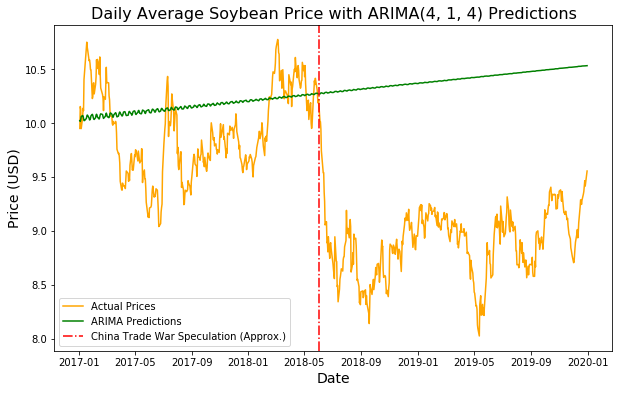

In [42]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot testing data.
plt.plot(test.index, test['Settlement Price'], color = 'orange', label = 'Actual Prices')

# Plot predicted test values.
plt.plot(test.index, forecast, color = 'green', label = 'ARIMA Predictions')

# Plot Approx China Trade War Speculation  
plt.axvline('2018-06', color = 'r', ls = '-.', label = 'China Trade War Speculation (Approx.)')

plt.ylabel('Price (USD)', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.legend()

plt.title(label = 'Daily Average Soybean Price with ARIMA(4, 1, 4) Predictions', fontsize=16);

Based on our seasonal decomposition, we know there is seasonality in the data.  I will know incorporate seasonality in the ARIMA model using a Seasonal ARIMA (SARIMA) model.

### SARIMA Model

Seasonality for the soybean crop in the US: planting = late April-June, harvesting = late September - November. So, seasonal periods seem to be approx 2.5-3 months each. So, I will gridsearch over the seasonality periods: 0, 30, 72 and 90. I will also use a little over 2 years of data in this search.  

In [20]:
len(train)

6805

In [22]:
train[:799]

,Settlement Price
Date,
1990-01-02,5.613
1990-01-03,5.673
1990-01-04,5.633
1990-01-05,5.645
1990-01-08,5.707
...,...
1993-02-22,5.707
1993-02-23,5.750
1993-02-24,5.753


In [23]:
best_aic = 99 * (10 ** 16)
best_P = 0
best_Q = 0
best_D = 0
best_S = 0

for P in range(3):
    for D in range(3):
        for Q in range(3):
            for S in [0,30,72,90]:
                try:        
                    print(f'Attempting to fit SARIMA(4, 1, 4) model with seasonal ({P},{D},{Q},{S}).')
                    # Instantiate SARIMAX model
                    sarima = sm.tsa.statespace.SARIMAX(endog = train[:799].astype(float).dropna(),
                                                       order = (4,1,4), 
                                                       seasonal_order = (P,D,Q,S)#,
                                                      #exog = X_train['precip_lag_1'].dropna()
                                                      )

                    # Fit SARIMA model.
                    model = sarima.fit()
                    
                    #Evaluate predictions
                    print(f'The AIC for (4,1,4)x({P},{D},{Q},{S}) is {model.aic}')
                    
                    # Is my current model's MAE better than our best_mae?
                    if best_aic>model.aic:
                        # If so, let's overwrite best_aic, best_p, and best_q.
                        best_aic = model.aic
                        best_P = P
                        best_D = D
                        best_Q = Q
                        best_S = S
            
                except:
                    pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC is the SARIMA(4,1,4)*({best_P},{best_D},{best_Q},{best_S}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit SARIMA(4, 1, 4) model with seasonal (0,0,0,0).
The AIC for (4,1,4)x(0,0,0,0) is -2074.5743968180286
Attempting to fit SARIMA(4, 1, 4) model with seasonal (0,0,0,30).
The AIC for (4,1,4)x(0,0,0,30) is -2074.5743968180286
Attempting to fit SARIMA(4, 1, 4) model with seasonal (0,0,0,72).
The AIC for (4,1,4)x(0,0,0,72) is -2074.5743968180286
Attempting to fit SARIMA(4, 1, 4) model with seasonal (0,0,0,90).
The AIC for (4,1,4)x(0,0,0,90) is -2074.5743968180286
Attempting to fit SARIMA(4, 1, 4) model with seasonal (0,0,1,0).
Attempting to fit SARIMA(4, 1, 4) model with seasonal (0,0,1,30).
The AIC for (4,1,4)x(0,0,1,30) is -2073.3867473823675
Attempting to fit SARIMA(4, 1, 4) model with seasonal (0,0,1,72).
The AIC for (4,1,4)x(0,0,1,72) is -2076.2083983680404
Attempting to fit SARIMA(4, 1, 4) model with seasonal (0,0,1,90).
Attempting to fit SARIMA(4, 1, 4) model with seasonal (0,0,2,0).
Attempting to fit SARIMA(4, 1, 4) model with seasonal (0,0,2,30).
The AIC for (4,1,4)x

The AIC for (4,1,4)x(2,0,1,72) is -2070.9710167573694
Attempting to fit SARIMA(4, 1, 4) model with seasonal (2,0,1,90).
The AIC for (4,1,4)x(2,0,1,90) is -2069.263680633683
Attempting to fit SARIMA(4, 1, 4) model with seasonal (2,0,2,0).
Attempting to fit SARIMA(4, 1, 4) model with seasonal (2,0,2,30).
The AIC for (4,1,4)x(2,0,2,30) is -2066.742060264107
Attempting to fit SARIMA(4, 1, 4) model with seasonal (2,0,2,72).
The AIC for (4,1,4)x(2,0,2,72) is -2074.0891361486156
Attempting to fit SARIMA(4, 1, 4) model with seasonal (2,0,2,90).
Attempting to fit SARIMA(4, 1, 4) model with seasonal (2,1,0,0).
Attempting to fit SARIMA(4, 1, 4) model with seasonal (2,1,0,30).
The AIC for (4,1,4)x(2,1,0,30) is -1740.9170986480885
Attempting to fit SARIMA(4, 1, 4) model with seasonal (2,1,0,72).
The AIC for (4,1,4)x(2,1,0,72) is -1592.774115132877
Attempting to fit SARIMA(4, 1, 4) model with seasonal (2,1,0,90).
The AIC for (4,1,4)x(2,1,0,90) is -1591.8330768604649
Attempting to fit SARIMA(4, 1, 4)

Running a gridsearch over a different section of the training data, with D=0 and S=72.

In [24]:
model_sm = sm.tsa.statespace.SARIMAX(endog = train.astype(float).dropna(),
                                     order = (4,1,4), 
                                     seasonal_order = (1,0,0,72))
sarimax = model_sm.fit()

In [25]:
forecast_sm = sarimax.forecast(len(test), step=1, alpha = 0.05)

In [26]:
print(f'MAE = {mean_absolute_error(test, forecast_sm)}')

MAE = 0.76976498443887


In [27]:
forecast_sm.index = test.index

In [28]:
resid_sm = test['Settlement Price']-forecast_sm
resid_sm

Date
2017-01-03   -0.074775
2017-01-04    0.129862
2017-01-05    0.094135
2017-01-06   -0.097505
2017-01-09   -0.001155
                ...   
2019-12-24   -0.671749
2019-12-26   -0.571749
2019-12-27   -0.621749
2019-12-30   -0.511749
2019-12-31   -0.481749
Length: 754, dtype: float64

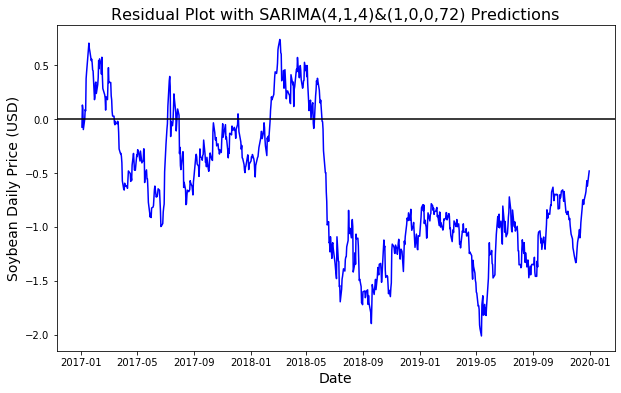

In [29]:
# Plot data.
plt.figure(figsize=(10,6))
plt.plot(resid_sm, color = 'blue')
plt.ylabel('Soybean Daily Price (USD)', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.title(label = 'Residual Plot with SARIMA(4,1,4)&(1,0,0,72) Predictions', fontsize=16)
plt.axhline(0, color = 'k', ls = '-')
plt.show();

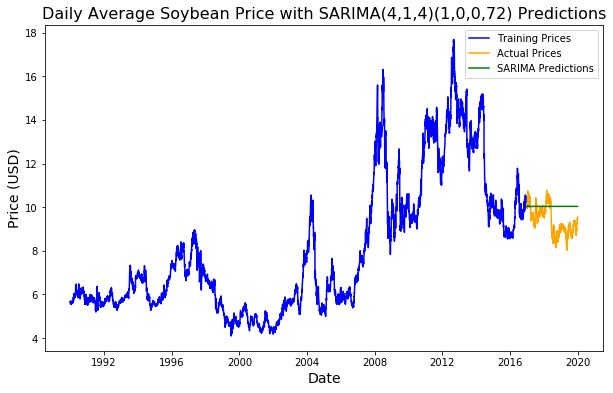

In [30]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot training data.
plt.plot(train.index, pd.DataFrame(train), color = 'blue', label = 'Training Prices')

# Plot testing data.
plt.plot(test.index, test['Settlement Price'], color = 'orange', label = 'Actual Prices')

# Plot predicted test values.
plt.plot(test.index, forecast_sm, color = 'green', label = 'SARIMA Predictions')

plt.ylabel('Price (USD)', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.legend()

plt.title(label = 'Daily Average Soybean Price with SARIMA(4,1,4)(1,0,0,72) Predictions', fontsize=16);

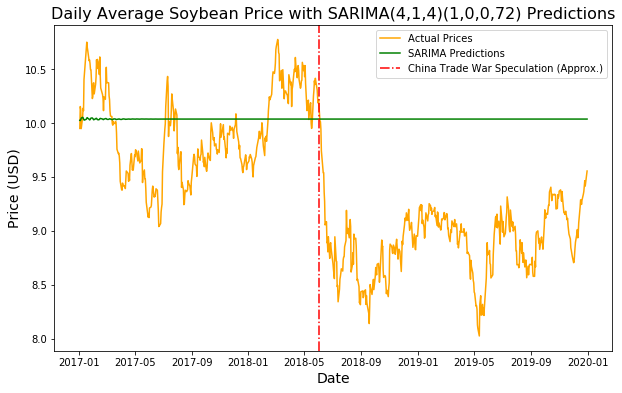

In [31]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot testing data.
plt.plot(test.index, test['Settlement Price'], color = 'orange', label = 'Actual Prices')

# Plot predicted test values.
plt.plot(test.index, forecast_sm, color = 'green', label = 'SARIMA Predictions')

# Plot Approx China Trade War Speculation  
plt.axvline('2018-06', color = 'r', ls = '-.', label = 'China Trade War Speculation (Approx.)')

plt.ylabel('Price (USD)', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.legend()

plt.title(label = 'Daily Average Soybean Price with SARIMA(4,1,4)(1,0,0,72) Predictions', fontsize=16);

In [32]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                    Settlement Price   No. Observations:                 6805
Model:             SARIMAX(4, 1, 4)x(1, 0, [], 72)   Log Likelihood                3703.516
Date:                             Wed, 11 Mar 2020   AIC                          -7387.032
Time:                                     05:09:37   BIC                          -7318.779
Sample:                                          0   HQIC                         -7363.480
                                            - 6805                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4386      0.534      0.822      0.411      -0.607       1.485
ar.L2         -0.2595      0.454     -0.571      0.568      -1.150       0.631
ar.L3         -0.4906      0.446     -1.099      0.272      -1.365       0.384
ar.L4         -0.1469      0.500     -0.294      0.769      -1.127       0.834
ma.L1         -0.4281      0.536     -0.799      0.424      -1.478       0.621
ma.L2          0.2611      0.450      0.580      0.562      -0.621       1.143
ma.L3          0.4968      0.440      1.128      0.259      -0.366       1.360
ma.L4          0.1301      0.498      0.261      0.794      -0.847       1.107
ar.S.L72      -0.0043      0.009     -0.491      0.624      -0.022       0.013
sigma2         0.0197   9.49e-05    207.637      0.000       0.020       0.020
===================================================================================
Ljung-Box (Q):                       90.79   Jarque-Bera (JB):            179871.07
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.20   Skew:                            -1.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

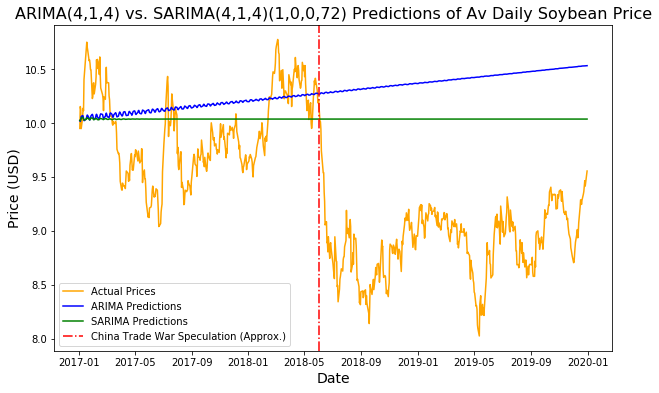

In [46]:
# Plot data.
plt.figure(figsize=(10,6))

# Plot testing data.
plt.plot(test.index, test['Settlement Price'], color = 'orange', label = 'Actual Prices')


# Plot ARIMA predicted test values.
plt.plot(test.index, forecast, color = 'blue', label = 'ARIMA Predictions')

# Plot SARIMA predicted test values.
plt.plot(test.index, forecast_sm, color = 'green', label = 'SARIMA Predictions')

# Plot Approx China Trade War Speculation  
plt.axvline('2018-06', color = 'r', ls = '-.', label = 'China Trade War Speculation (Approx.)')

plt.ylabel('Price (USD)', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.legend()

plt.title(label = 'ARIMA(4,1,4) vs. SARIMA(4,1,4)(1,0,0,72) Predictions of Av Daily Soybean Price', fontsize=16);
plt.savefig('../Images/predictions_ARIMA_SARIMA.png')